In [ ]:
pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [ ]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [ ]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

In [ ]:
get_movie_title_by_id('movie_1')

'Toy Story (1995)'

In [ ]:
get_movie_id_by_title('Pulp Fiction (1994)')

'movie_296'

# Construct the Movies graph

###### We create an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. The weight of the edge will be based on the pointwise mutual information between the two movies, which is computed as: log(xy) - log(x) - log(y) + log(D), where:

###### xy is how many users rated both movie x and movie y with >= min_rating.
###### x is how many users rated movie x >= min_rating.
###### y is how many users rated movie y >= min_rating.
###### D total number of movie ratings >= min_rating.

### Step 1: create the weighted edges between movies.

In [ ]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1              # the final value of item_frequency is "how many users rated movie x"  the sum of the users who rated movie x starting by one user to an other
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])   # we used min and max to have a sorted form of each pair to avoid duplication of pairs between the users when the there is the same pair but in different order ex: (movie_1,movie_2) and (movie_2,movie_1) or just to have a sorted form of the pairs
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1                     # the final value of pair_frequeny is "how many users rated both movies x and y " the sum of the users who rated both movies x and y starting by one user to the other 

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 990.68it/s]


### Step 2: create the graph with the nodes and the edges

###### To reduce the number of edges between nodes, we only add an edge between movies if the weight of the edge is greater than min_weight.

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 631746.86it/s]


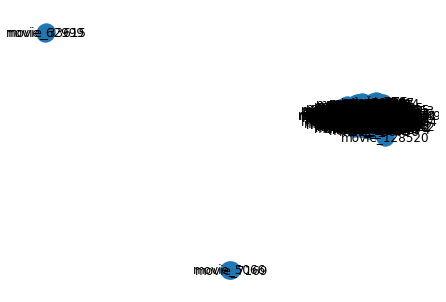

In [ ]:
min_weight = 10
D = math.log(sum(item_frequency.values()))          # total number of ratings

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)


nx.draw(movies_graph, with_labels=True)
plt.show()

###### Let's display the total number of nodes and edges in the graph

In [ ]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


Let's display the average node degree (number of neighbours) in the graph.

In [ ]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


### Step 3: Create vocabulary and a mapping from tokens to integer indices

In [ ]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [ ]:
print(list(movies_graph.nodes))

['movie_47', 'movie_50', 'movie_151', 'movie_163', 'movie_216', 'movie_231', 'movie_260', 'movie_333', 'movie_457', 'movie_527', 'movie_596', 'movie_608', 'movie_1029', 'movie_1073', 'movie_1080', 'movie_1089', 'movie_1136', 'movie_1196', 'movie_1197', 'movie_1198', 'movie_1206', 'movie_1210', 'movie_1213', 'movie_1220', 'movie_1222', 'movie_1240', 'movie_1270', 'movie_1275', 'movie_1278', 'movie_1291', 'movie_1517', 'movie_1573', 'movie_1617', 'movie_1625', 'movie_1732', 'movie_2005', 'movie_2094', 'movie_2115', 'movie_2116', 'movie_2329', 'movie_2387', 'movie_2459', 'movie_2470', 'movie_2502', 'movie_2529', 'movie_2542', 'movie_2571', 'movie_2700', 'movie_2716', 'movie_2858', 'movie_2949', 'movie_2959', 'movie_2987', 'movie_3033', 'movie_3052', 'movie_3147', 'movie_3253', 'movie_3386', 'movie_3441', 'movie_3578', 'movie_3671', 'movie_3703', 'movie_101', 'movie_362', 'movie_553', 'movie_923', 'movie_1097', 'movie_1282', 'movie_1587', 'movie_1954', 'movie_2058', 'movie_2078', 'movie_23

In [ ]:
print(vocabulary)

['NA', 'movie_47', 'movie_50', 'movie_151', 'movie_163', 'movie_216', 'movie_231', 'movie_260', 'movie_333', 'movie_457', 'movie_527', 'movie_596', 'movie_608', 'movie_1029', 'movie_1073', 'movie_1080', 'movie_1089', 'movie_1136', 'movie_1196', 'movie_1197', 'movie_1198', 'movie_1206', 'movie_1210', 'movie_1213', 'movie_1220', 'movie_1222', 'movie_1240', 'movie_1270', 'movie_1275', 'movie_1278', 'movie_1291', 'movie_1517', 'movie_1573', 'movie_1617', 'movie_1625', 'movie_1732', 'movie_2005', 'movie_2094', 'movie_2115', 'movie_2116', 'movie_2329', 'movie_2387', 'movie_2459', 'movie_2470', 'movie_2502', 'movie_2529', 'movie_2542', 'movie_2571', 'movie_2700', 'movie_2716', 'movie_2858', 'movie_2949', 'movie_2959', 'movie_2987', 'movie_3033', 'movie_3052', 'movie_3147', 'movie_3253', 'movie_3386', 'movie_3441', 'movie_3578', 'movie_3671', 'movie_3703', 'movie_101', 'movie_362', 'movie_553', 'movie_923', 'movie_1097', 'movie_1282', 'movie_1587', 'movie_1954', 'movie_2058', 'movie_2078', 'mo

In [ ]:
print(vocabulary_lookup)

{'NA': 0, 'movie_47': 1, 'movie_50': 2, 'movie_151': 3, 'movie_163': 4, 'movie_216': 5, 'movie_231': 6, 'movie_260': 7, 'movie_333': 8, 'movie_457': 9, 'movie_527': 10, 'movie_596': 11, 'movie_608': 12, 'movie_1029': 13, 'movie_1073': 14, 'movie_1080': 15, 'movie_1089': 16, 'movie_1136': 17, 'movie_1196': 18, 'movie_1197': 19, 'movie_1198': 20, 'movie_1206': 21, 'movie_1210': 22, 'movie_1213': 23, 'movie_1220': 24, 'movie_1222': 25, 'movie_1240': 26, 'movie_1270': 27, 'movie_1275': 28, 'movie_1278': 29, 'movie_1291': 30, 'movie_1517': 31, 'movie_1573': 32, 'movie_1617': 33, 'movie_1625': 34, 'movie_1732': 35, 'movie_2005': 36, 'movie_2094': 37, 'movie_2115': 38, 'movie_2116': 39, 'movie_2329': 40, 'movie_2387': 41, 'movie_2459': 42, 'movie_2470': 43, 'movie_2502': 44, 'movie_2529': 45, 'movie_2542': 46, 'movie_2571': 47, 'movie_2700': 48, 'movie_2716': 49, 'movie_2858': 50, 'movie_2949': 51, 'movie_2959': 52, 'movie_2987': 53, 'movie_3033': 54, 'movie_3052': 55, 'movie_3147': 56, 'movi

In [ ]:
print(len(vocabulary))

1406


# Implement the biased random walk

In [ ]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))    # Returns an iterator over all neighbors of node n.

    weights = []         # weight of each edge between two movies
    
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

# Generate training data using the biased random walk

In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:06<00:00, 220.25it/s]

Number of walks generated: 7025


In [ ]:
print("Number of nodes or movies in walk number 1:", len(walks[0]))
print("Number of nodes or movies in walk number 7025:", len(walks[7024]))

Number of nodes or movies in walk number 1: 10
Number of nodes or movies in walk number 7025: 10


In [ ]:
for i in range(10):
  print(walks[i])

[57, 6, 176, 391, 937, 322, 350, 656, 306, 34]
[208, 163, 974, 171, 656, 415, 416, 16, 2, 449]
[1099, 12, 714, 1352, 433, 50, 201, 541, 770, 702]
[515, 19, 16, 19, 211, 716, 419, 256, 680, 338]
[1146, 448, 23, 461, 863, 542, 224, 1028, 668, 73]
[120, 1, 18, 52, 782, 1101, 984, 1101, 273, 1014]
[1164, 273, 558, 106, 668, 743, 1180, 319, 598, 24]
[746, 847, 207, 246, 1107, 669, 160, 50, 823, 260]
[632, 855, 1254, 62, 1254, 1177, 655, 16, 838, 514]
[416, 272, 126, 970, 126, 641, 302, 49, 78, 407]


# Generate positive and negative examples

In [ ]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:13<00:00, 514.59it/s]


##### Let's display the shapes of the outputs

In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (881813,)
Contexts shape: (881813,)
Labels shape: (881813,)
Weights shape: (881813,)


### Convert the data into tf.data.Dataset objects

In [ ]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)


# Train the skip-gram model

In [ ]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

### Implement the model

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Train the model

In [ ]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

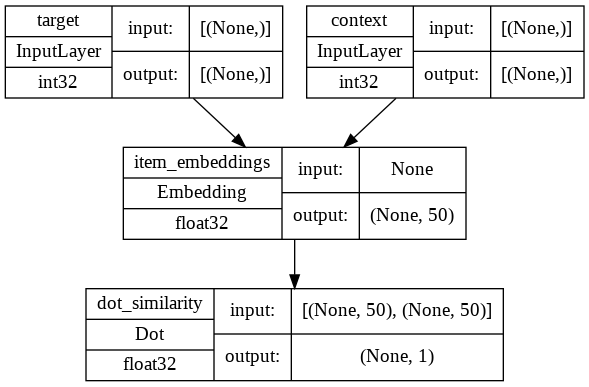

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [ ]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
861/861 [==============================] - 5s 5ms/step - loss: 2.4455
Epoch 2/10
861/861 [==============================] - 6s 7ms/step - loss: 2.3392
Epoch 3/10
861/861 [==============================] - 4s 5ms/step - loss: 2.3328
Epoch 4/10
861/861 [==============================] - 5s 6ms/step - loss: 2.3293
Epoch 5/10
861/861 [==============================] - 4s 5ms/step - loss: 2.3253
Epoch 6/10
861/861 [==============================] - 5s 6ms/step - loss: 2.3212
Epoch 7/10
861/861 [==============================] - 5s 6ms/step - loss: 2.3176
Epoch 8/10
861/861 [==============================] - 5s 5ms/step - loss: 2.3144
Epoch 9/10
861/861 [==============================] - 4s 5ms/step - loss: 2.3117
Epoch 10/10
861/861 [==============================] - 5s 6ms/step - loss: 2.3089


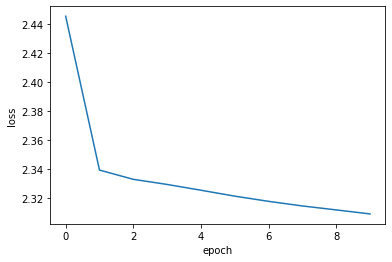

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Analyze the learnt embeddings

In [ ]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


### Find related movies

In [ ]:
query_movies = [
    "Matrix, The (1999)"
]

In [ ]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [ ]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [ ]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Fight Club (1999)
- Matrix, The (1999)
- Star Wars: Episode IV - A New Hope (1977)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Lord of the Rings: The Fellowship of the Ring, The (2001)



### Visualize the embeddings using the Embedding Projector

In [ ]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()

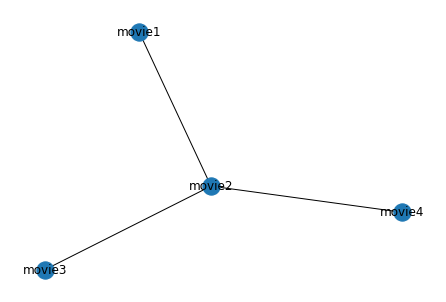

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edge('movie1','movie2', weight = 1)
G.add_edge('movie2','movie3', weight = 2 )
G.add_edge('movie2','movie4', weight = 3)
nx.draw(G, with_labels=True)
plt.show()